## Marketing Analytics

### A/B Testing

#### What is it?

A/B testing, also known as split testing or bucket testing, is a methodology used to evaluate and compare the performance of two or more versions of a feature. It is often associated with changes in websites and apps. Its importance lies in the fact that we can identify which variation leads to a better performance, using statistical analysis. Thus, no guessing is used to determine which variation leads to a better result. A/B test can provide accurate answer - quickly, as it is performed online and in a real-time envinronment.

#### How is it done?

    1. Designing our experiment
    2. Collecting and preparing the data
    3. Visualising the results
    4. Testing the hypothesis
    5. Drawing conclusions

#### Business Problem

Let's suppose we have a business where we sell products online. While browsing through the website, the user can read the comments and see ratings left by customers who broght the product. The company is interested to know whether displaying previous customer's comments and ratings affects the sales, and if removing them from the website could possibly increase their sales.

### Objective
The goal here is to practice analysis of A/B Testing results using Python, to find out whether removing user's comments and ratings increase sales or not.

#### Scope

This notebook does not cover the whole A/B Testing process. It focuses on the analysis of the data generated in the experiment, i.e., we will look at output of the experiment, prepare the data for analysis, create some visualizations for better understanding, apply statistics to compare the groups and then draw conclusions.

In [1]:
# Load packages
import numpy as np
import pandas as pd
import datetime as dt 
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as scs

from helper import *
%matplotlib inline

In [2]:
# Load data and preview dataset
df = pd.read_csv('input/dataset.csv')
print(df.head().append(df.tail()))

             id variant   sale        date
0      0x6f9421       A  False  2019-12-26
1      0x59d442       A  False  2019-08-16
2      0x6db8f8       A   True  2019-03-18
3      0x68245d       A  False  2019-02-13
4      0x28566e       A  False  2019-09-28
54995  0x451451       A  False  2019-06-19
54996  0x871d51       A  False  2019-03-22
54997  0x50d163       A  False  2019-02-10
54998  0x3544c4       B  False  2020-01-09
54999  0x983331       A  False  2019-09-05


## Exploratory Analysis

In [3]:
print('Dataset contains {} rows and {} columns.' .format(df.shape[0], df.shape[1]))
df.dtypes

Dataset contains 55000 rows and 4 columns.


id         object
variant    object
sale         bool
date       object
dtype: object

In [4]:
# Dataset contains 55000 unique ids
df.nunique()

id         55000
variant        2
sale           2
date         395
dtype: int64

In [5]:
# Date range 
print('Period of analysis ranges from {} to {}.' .format(df.date.min(), df.date.max()))

Period of analysis ranges from 2019-01-01 to 2020-01-30.


In [6]:
# Data does not have missing data
df.isnull().sum()

id         0
variant    0
sale       0
date       0
dtype: int64

In [7]:
# Total conversion
df.sale.value_counts()

False    46416
True      8584
Name: sale, dtype: int64

In [8]:
# Let's calculate some probabilities
print('There was a {:.2f} probability of a user to be shown A variant, and {:.2f} probability to be shown the B variant.' .format(df[df.variant=='A'].shape[0]/df.shape[0],1-df[df.variant=='A'].shape[0]/df.shape[0]))

There was a 0.91 probability of a user to be shown A variant, and 0.09 probability to be shown the B variant.


In [9]:
print('Out of the {} registers, {} generated a sale, where {} came from the A variant, and {} from the B variant.' .format(df.shape[0], df[df.sale==1].shape[0],df[(df.sale==1)&(df.variant=='A')].shape[0],df[(df.sale==1)&(df.variant=='B')].shape[0]))

Out of the 55000 registers, 8584 generated a sale, where 7603 came from the A variant, and 981 from the B variant.


In [10]:
# Probability of conversion
print('Probability of conversion: {:.3f}' .format(df.sale.mean()))
print('Probability of conversion: {:.3f} for A group.' .format(df[df.variant=='A'].sale.mean()))
print('Probability of conversion: {:.3f} for B group.' .format(df[df.variant=='B'].sale.mean()))

Probability of conversion: 0.156
Probability of conversion: 0.152 for A group.
Probability of conversion: 0.196 for B group.


By looking at the probabilities, we can see that there's a 16% chance of sale when no changes were made in the webpage, and 20% when users were exposed to the modified variant. Can we say that the website with the B variant increase the product sales?

In order to answer this question, we need to determine if the difference is statistically significant. We do that by defining and testing a hypothesis.


## Hypothesis Test

To ensure that hypothesis tests are carried out properly, it is useful to have a well-defined process for conducting them:

    1. Specify the parameter to be tested
    2. State the null and alternative hypothesis
    3. State the alpha value
    4. Determine the test statistic
    5. Define the rejection criteria
    6. Compute the critical values
    7. Compute the test statistic
    8. State the conclusion of the test 

So let's go through these steps. What we want to understand here is if user evaluation increase online product sales.

A: it displays the current number of comments and customers evaluation

B: it doesn't display any comments or evaluation




### 1. Specify the parameter to be tested

The parameter we want to test is the conversion rate, p

### 2. State the null and alternative hypothesis

Let's define $p_{A}$ e $p_{B}$, as being the conversion probabilities for variants A and B, respectively.

- H0: Pb - Pa = 0
- H1: Pb - Pa > 0

The null hypothesis H0 states that the probability difference of both groups is zero.

The alternative hypothesis H1 states that the probability difference of both groups is larger than zero.

### 3. State the alpha value

So what we're going to test is whether we can reject the null hypothesis with 95% confidence. We also set some parameters to our experiment.

In [11]:
alpha = 0.05 # Significance level

### 4. Determine the test statistic 

$$ \hat{p} = \frac{n_1p_1+n_2p_2}{n_1+n_2}$$

$$ z_0 = \frac{{p_1}-{p_2}}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1}+\frac{1}{n_2})}}$$

### 5. Define the rejection criteria

Reject H_0 if 
$$z_0 > z_a$$

### 6. Compute the critical values



In [12]:
z_alpha = scs.norm.ppf(1 - alpha)
z_alpha

1.6448536269514722

### 7. Compute the test statistic

### Baseline

We can create a baseline to be able to compare our results once we run the hypothesis test.

In [13]:
df['month_year'] = df['date'].apply(lambda x: x[:7])
df_partial = df[df.month_year=='2020-01']
df_summary = df_partial.groupby('variant').agg({'sale': [ 'size', 'sum','mean']})
df_summary.columns = ['size','total','mean']
df_summary.reset_index(drop = False, inplace = True)
df_summary

,variant,size,total,mean
0,A,3821,587.0,0.153625
1,B,5000,981.0,0.196200


From the table above we can define the baseline conversion rate as the conversion rate of the variant A, where no changes were made.

We can also calculate the minimum detectable effect (MDE), which represents the minimum improvement  over the baseline that you're willing to detect in an experiment, to a certain degree of statistical significance.

In [14]:
# Baseline conversion set to A
baseline_conversion = df_summary['mean'][0]

# Minimum detectable effect (MDE)
mde = df_summary['mean'][1] - df_summary['mean'][0]
print('MDE: {:.5f}' .format(mde))

MDE: 0.04258


In [15]:
# Let's also set the values to some variables, that will make it easier to work with the data
pa = df_summary['mean'][0]
pb = df_summary['mean'][1]
na = df_summary['size'][0]
nb = df_summary['size'][1]
xa = df_summary['total'][0]
xb = df_summary['total'][1]

In [16]:
# Now let's calculate the statistic test
pooled_prob = (pa * na + pb * nb) / (na + nb)

z = (pb - pa) / (pooled_prob * (1 - pooled_prob) * (1 / na + 1 / nb))**0.5
z

5.1827257006909795

### 8. State the conclusion of the test 

In [17]:
# Verify if z is greater than z_alpha(for a significancy level of 5%)
z > z_alpha

True

Since z > z_alpha, we can reject the null hypothesis and state that we have enough data to infer that the probabilities found are different, and that removing user comments and ratings indeed increase online sales.

Let's now take a look at some distributions

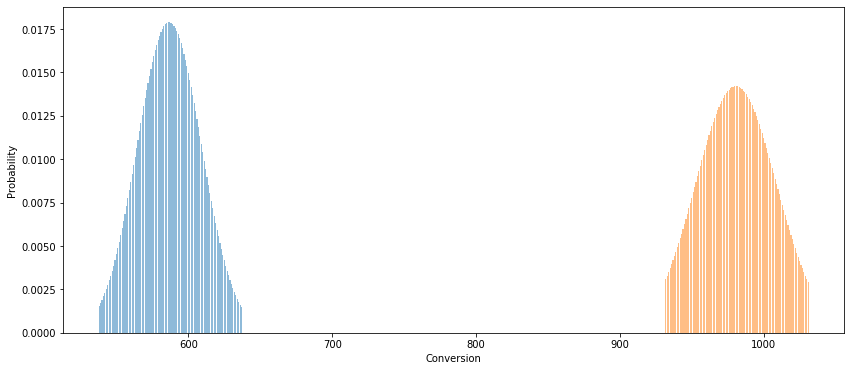

In [18]:
# A and B distribution plot

fig, ax = plt.subplots(figsize = (14,6))

# A
xA = np.linspace(xa - 49, xa + 50, 100)
yA = scs.binom(na, pa).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# B
xB = np.linspace(xb - 49, xb + 50, 100)
yB = scs.binom(nb, pb).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability');

From the above graph, we can notice that B variant led to more conversions than the control variant A. We can also see that B had a lower peak. But it is difficult to interpret the difference presented. 

Therefore we focus on the conversion rate to compare the data. We need to standardize the data and compare the p probability for each group.

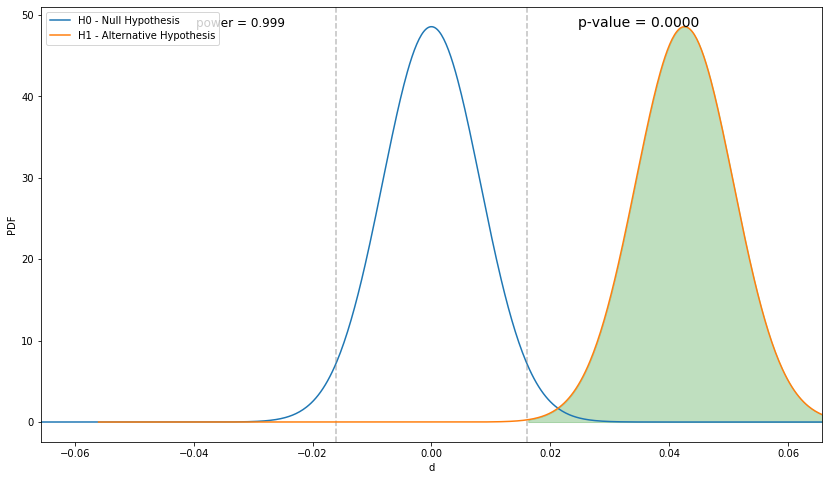

In [19]:
abplot_func(na, nb, baseline_conversion, mde, show_p_value = True)

In the plot above, both distributions seems to have the same format, so we can compare the distance between them. The alternative plot suggests that the treatment group B has a higher conversion than A.

The green shaded area represents the power whose value is also displayed in the plot. The gray dashed line display the confidence interval for the null hypothesis.

The statistical power is the area below the alternative variant B which is not within the confidence interval of the null hypothesis.

If the null hypothesis is true and there is really no difference betwen A and B groups, then the significance level is the probability of rejecting the null hypothesis and accepting the altenative hypothesis(false positive). A false positive means that we concluded that the new design was better although that was not true.

Most experiments are designed to have a minimum power of 80%. That means that we would like our experiment to have at least 80% probability that the new design is indeed better.

One way to increase the power is to increase the sample size.

## Sample size

In order to make a statistically significant decision, it is important that a hypothesis test and confidence intervals use the proper sample size. Moreover, identifying the required sample size can allow us to decide whether we can already conclude the experiment and provide significant statistically results to the business area.

The sample size depends on parameters such as:

- Power of the test (1- beta)
- Alpha value (alpha)
- Minimum detectable effect

Which can be used to calculate the sample size:

$$ n_A = k*n_B $$

$$ n_B = (\frac{p_A(1-p_A)}{k}+p_B(1-p_B)) (\frac{Z_{1-\alpha} + Z_{1-\beta}}{p_A-p_B})^{2}$$

$$ n = \frac{2(\bar{p})(1-\bar{p})(Z_{1-\beta}+Z_{1-\alpha})^2}{(p_B-p_A)^2}$$

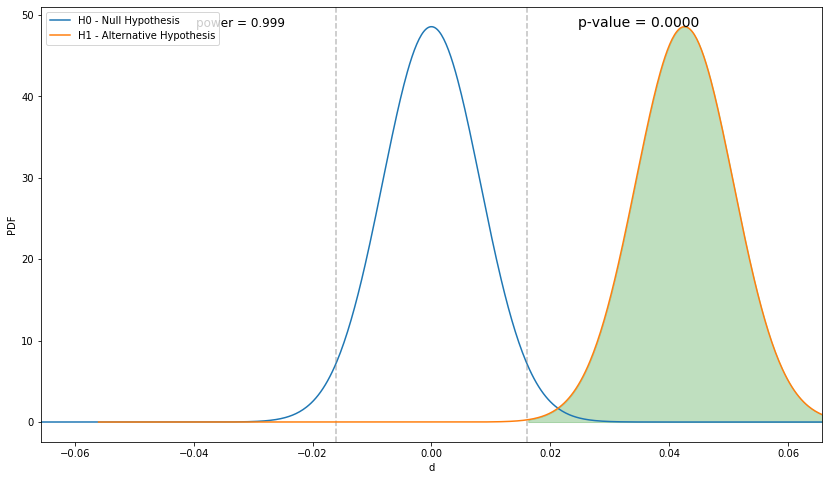

In [20]:
abplot_func(na, nb, baseline_conversion, mde, show_p_value = True)

In [21]:
# Calculate Z alpha and beta
beta = 0.2
k = na/nb
standard_norm = scs.norm(0, 1)
Z_beta = standard_norm.ppf(1-beta)
Z_alpha = standard_norm.ppf(1-alpha)

In [22]:
# Calculate the minimum sample size required
minimum_sample_size(na, nb, pa, pb, power = (1-beta), sig_level = alpha, two_sided = False)

1249.8068972849476

## Baseline comparison

In [23]:
# Pooled probability for the baseline
pooled_prob = (baseline_conversion + baseline_conversion + mde) / 2
pooled_prob

0.1749123527872285

In [24]:
# Minimum sample size for the baseline
min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / mde**2)
min_N

984.4720435225323

# Statistical power

What would happen with the statistical power if we had different sample sizes?

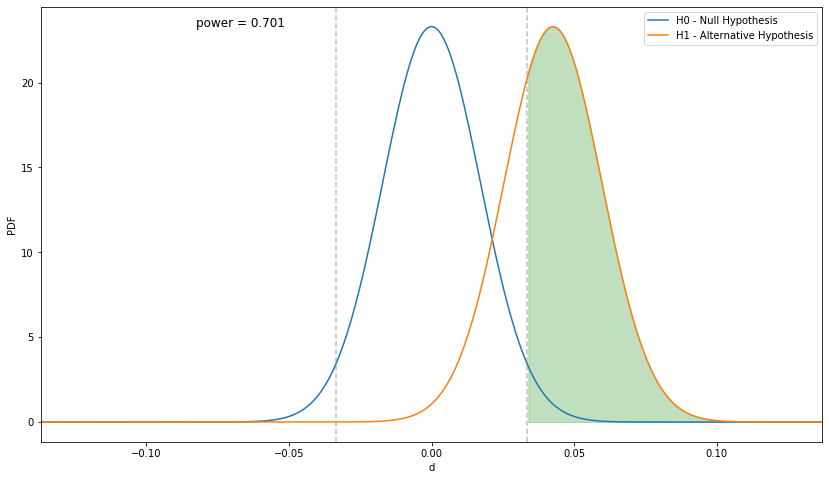

In [25]:
# plot the distributions for a sample size of 984
abplot_func(N_A = 984, 
            N_B = 984, 
            bcr = pa, 
            d_hat = mde, 
            sig_level = alpha, 
            show_p_value = False, 
            show_legend = True)

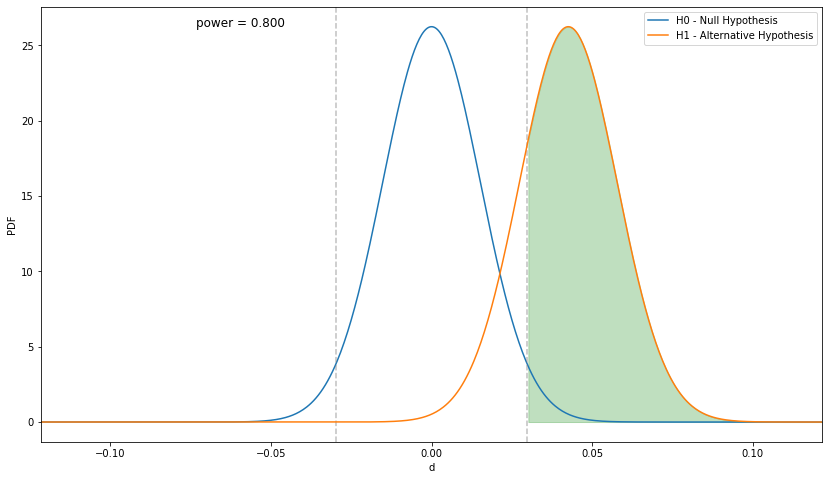

In [26]:
# plot the distributions for a sample size of 1249
abplot_func(N_A = 1249, 
            N_B = 1249, 
            bcr = pa, 
            d_hat = pb-pa, 
            sig_level = alpha, 
            show_p_value = False, 
            show_legend = True)

## Conclusion

As we have seen, we can indeed infer that the changes in the webpage really increased the online sales, with a power of 80%. 
Also, the minimum sample size required to deem that statistically significant would be 1249.